Применим сезонность для ARIMA

![SARIMA](1_13.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
def smape(A, F):
    return 100*np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [3]:
data = pd.read_csv("https://video.ittensive.com/time-series/ittensive.time.series.02.csv",
                   delimiter=";", header=0, names=["Дата", "Курс", "Ипотека"])
data = data[::-1].reset_index().drop(labels="index", axis=1)
data.head()

,Дата,Курс
0,11.01.2022,75.1315
1,12.01.2022,74.8355
2,13.01.2022,74.5277
3,14.01.2022,74.5686
4,15.01.2022,75.7668


## Подбираем коэффициенты

Модель SARIMA использует шесть целочисленных параметра: p, d, q, P, D, Q.

* p – порядок авторегрессии (AR). Его можно интерпретировать как выражение «элемент ряда будет близок к Х, если предыдущие р элементов были близки к Х».
* d – порядок интегрирования (I) разностей исходного временного ряда. Можно понимать как «элемент будет близок по значению к предыдущим d элементам, если их разность минимальна».
* q – порядок скользящего среднего (MA), который позволяет установить погрешность модели как линейную комбинацию наблюдавшихся ранее значений ошибок.
* P - порядок сезонной авторегрессии
* D - порядок сезонного интегрирования
* Q - порядок сезонного скользящего среднего
* T (период сезона) - 7

## Строим модель

In [4]:
model = SARIMAX(data["Курс"], order=(2, 1, 3), seasonal_order=(1,1,1,7)).fit()
print (model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                Курс   No. Observations:                  159
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 7)   Log Likelihood                -354.564
Date:                             Sun, 25 Sep 2022   AIC                            725.129
Time:                                     00:39:48   BIC                            749.267
Sample:                                          0   HQIC                           734.935
                                             - 159                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4578      0.097     15.069      0.000       1.268       1.647
ar.L2         -0.7441      

C:\Users\Lenovo PC\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Переберем все коэффициенты "по сетке", выберем лучший вариант AIC

In [5]:
aic_best = model.aic
seasonal_coeff_best = (1, 1, 1, 7)
for P in range(1,3):
    for D in range(1,3):
        for Q in range(1,3):
            model_ = SARIMAX(data["Курс"], order=(2, 1, 3), seasonal_order=(P, D, Q, 7)).fit()
            aic = model_.aic
            if aic < aic_best:
                seasonal_coeff_best = (P, D, Q, 7)
                aic_best = aic
print ("Наилучшие коффициенты:", seasonal_coeff_best)

C:\Users\Lenovo PC\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Lenovo PC\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Lenovo PC\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Lenovo PC\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting

Наилучшие коффициенты: (1, 1, 1, 7)


## Визуализация результата

In [6]:
model = SARIMAX(data["Курс"][:-10], order=(2, 1, 3), seasonal_order=seasonal_coeff_best).fit()
forecast = model.get_forecast(steps=10).predicted_mean

C:\Users\Lenovo PC\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


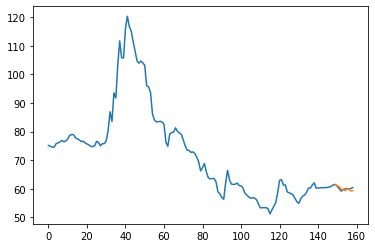

In [7]:
plt.plot(data["Курс"])
plt.plot(forecast)
plt.show()

Оценим ошибку

In [8]:
print ("Ошибка модели:", smape(data["Курс"][-10:], forecast))

Ошибка модели: 7.053594196283116
